We pretty much failed with normal regression, but its comprehensible:
- we reduced the number of features available to the model by averaging the cortical thickness
- we are dealing with an inherently difficult problem where the connection may not be trivially linear
- we haven't tried some other approaches in literature (left for you as an excercise)

At this point, it's time for Deep Learning!

We will now try to predict Brain Age based on MRI scans. We will cover
- preprocessing of the scans
- implementation of a possible model
- training, validation
- improvements
- transfer learning

let's go!

In [1]:
# !pip install monai==1.5.0 --no-dependencies

In [2]:
# Imports
# General purpose
import os
import random
# # DL
import torch as th
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
# Data
import pandas as pd
import nibabel as nib
from torch.utils.data import Dataset, DataLoader
import monai.transforms as mtr
from sklearn.model_selection import StratifiedKFold, train_test_split
# Visualize
import matplotlib.pyplot as plt
import tqdm

In [3]:
# We download instead a preprocessed version (will be explained...)
# !mkdir ../data
# !curl -L -o ../data/preprocessed-ixi-dataset-with-fs8.zip -z ../data/preprocessed-ixi-dataset-with-fs8.zip https://www.kaggle.com/api/v1/datasets/download/kingpowa/preprocessed-ixi-dataset-with-fs8
# !unzip -n ../data/preprocessed-ixi-dataset-with-fs8.zip -d ../data
# !mkdir ../data/IXI
# !mv -v ../data/T1w_Processed_IXI_with_csv/IXI/* ../data/IXI
# !rm -rf ../data/preprocessed-ixi-dataset-with-fs8.zip
# !rm -rf ../data/T1w_Processed_IXI_with_csv

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [5]:
th.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [6]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [7]:
masterfile_path = "../data/IXI/subjects.csv"
masterfile = pd.read_csv(masterfile_path)
masterfile = masterfile[masterfile["age"] != -1.0]
masterfile.head(5)

,subject_id,age,sex,scanner,site,diagnosis,dataset_name,subject_key,session,run,registered_mni
0,IXI002,35.80,Female,Philips-1.5T,Guy’s-Hospital,Healthy,IXI,IXI002_IXI,1,1,sub-IXI002/ses-1/run-1/anat/sub-IXI002_acq-Phi...
1,IXI012,38.78,Male,Philips-3.0T,Hammersmith-Hospital,Healthy,IXI,IXI012_IXI,1,1,sub-IXI012/ses-1/run-1/anat/sub-IXI012_acq-Phi...
2,IXI013,46.71,Male,Philips-3.0T,Hammersmith-Hospital,Healthy,IXI,IXI013_IXI,1,1,sub-IXI013/ses-1/run-1/anat/sub-IXI013_acq-Phi...
3,IXI014,34.24,Female,Philips-3.0T,Hammersmith-Hospital,Healthy,IXI,IXI014_IXI,1,1,sub-IXI014/ses-1/run-1/anat/sub-IXI014_acq-Phi...
4,IXI015,24.28,Male,Philips-3.0T,Hammersmith-Hospital,Healthy,IXI,IXI015_IXI,1,1,sub-IXI015/ses-1/run-1/anat/sub-IXI015_acq-Phi...


Let's create a class to handle the data

We use the `torch` `Dataset` interface for this

To handle the MRI data we use `monai`. Monai is a library for neuroimaging that implements useful transformations for our data.

In [8]:
class MRIDataset(Dataset):
    def __init__(self,
                 metadata_df: pd.DataFrame,
                 base_path = "../data/IXI",
                 transform = None,
                 age_transforms = None):
        self.df = metadata_df
        self.transform = transform
        self.age_transforms = age_transforms
        self.base_path = base_path

        self.img_loader = mtr.LoadImage(image_only=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        vol = self.img_loader(os.path.join(self.base_path, row["registered_mni"][:-3]))
        age = float(row["age"])
        if self.transform:
            vol = self.transform(vol)
        if self.age_transforms:
            age = self.age_transforms(age)
        return {
            "t1n": vol if th.is_tensor(vol) else th.as_tensor(vol),
            "age": (age if th.is_tensor(age) else th.as_tensor(age)).type(dtype=th.float32),
        }

In [9]:
ds = MRIDataset(
    metadata_df=masterfile
)

ds[0]

{'t1n': metatensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,

Let's see if what we are getting makes sense

In [10]:
def show_brain(img, slice_idx = "half"):
    if isinstance(slice_idx, str) and slice_idx == "half":
        points = [x//2 for x in img.shape[-3:]]
    else:
        points = [slice_idx for _ in range(3)]

    fig, ax = plt.subplots(1,3, figsize=(6,21))
    img_to_show = img
    while len(img_to_show.shape) > 3:
        img_to_show = img_to_show[0]

    ax[0].imshow(img_to_show[points[0]], cmap="Greys_r")
    ax[1].imshow(img_to_show[:,points[1]], cmap="Greys_r")
    ax[2].imshow(img_to_show[:,:,points[2]], cmap="Greys_r")
    plt.show()

In [11]:
sample = ds[0]

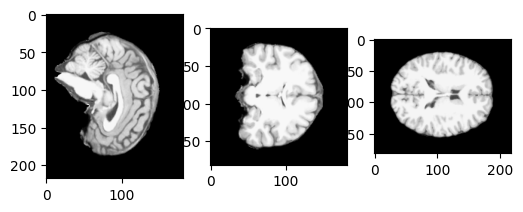

(metatensor(0.), metatensor(141.))

In [12]:
show_brain(sample["t1n"])
(sample["t1n"].min(), sample["t1n"].max())

It makes sense, but someone may have noticed that the images are not normalised.
This is an usual step in every DL pipeline. So let's do it from now.

Normalization helps making gradients of DL models more stable, as we remove extreme values from the images and allows us to make them more similar with each other, removing some unwanted differences. We will retain individual differences, but will be easier for DL methods to handle this type of data.

In [13]:
transforms = mtr.Compose([
    mtr.Lambda(lambda x: x/255.) # Or min-max scaling. Why no min-max?
])

ds.transform = transforms

In [14]:
ds[0]

{'t1n': metatensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,

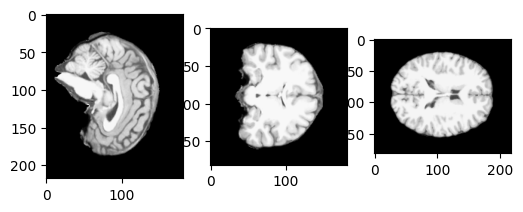

(metatensor(0.), metatensor(0.5529))

In [15]:
sample = ds[0]
show_brain(sample["t1n"])
(sample["t1n"].min(), sample["t1n"].max())

Nothing has changed visually speaking, but this will improve the training.

For our DL task, we will need similar evaluations as we did for regression. So, let's apply again our division

In [16]:
test_set = masterfile[masterfile["scanner"] == "GE-1.5T"]
train_set = masterfile[masterfile["scanner"] != "GE-1.5T"]

test_set["subject_id"].nunique(), train_set["subject_id"].nunique()

(66, 494)

We will use CV for our task.
Deep learning model requires heavy amount of data to learn useful patterns in our data. For training our model, using CV is mandatory since our sample size is very low.

However, for time purposes, I will show here the normal split

In [17]:
internal_df = train_set.copy()
internal_df["age_bin"] = pd.cut(train_set["age"], bins=10, labels=False, include_lowest=True)
internal_df["stratify_key"] = internal_df["age_bin"].astype(str) + "_" + internal_df["sex"].astype(str)

# What we should do
# skf = StratifiedKFold(n_splits = 3, shuffle = False)
# What I will do
train_idx, val_idx = train_test_split(np.arange(len(internal_df)),
                                       train_size=0.8,
                                       random_state=0,
                                       shuffle=True,
                                       stratify=internal_df["stratify_key"].values)

We will now create a very simple CNN for 3D Data. For this end, let's see the size of our mri scan

In [18]:
ds[0]["t1n"].shape

torch.Size([182, 218, 182])

The size is very large, and this can become quickly a problem for our network. Let's implement a transformation that crops this volume to a given size. We should calculate optimal crop. I did already this for you (kinda), and we can use a fixed known crop

In [19]:
transforms = mtr.Compose([
    mtr.EnsureChannelFirst(),
    mtr.SpatialCrop(
        roi_start = (6, 2, 0),
        roi_end = (173, 214, 160),
    ),
    mtr.Lambda(lambda x: x/255.)
])

ds.transform = transforms

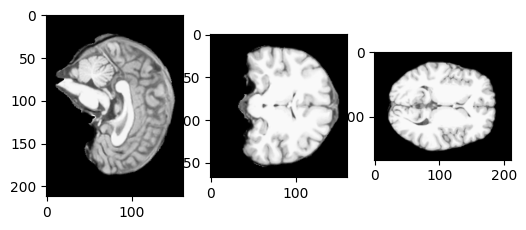

torch.Size([1, 167, 212, 160])

In [20]:
sample = ds[0]
show_brain(sample["t1n"])
sample["t1n"].shape

We greatly reduced the dimensionality. This will be insanely useful in training.

Let's now create a simple 3D CNN

In [21]:
class Simple3DCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 8, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(8)
        self.conv2 = nn.Conv3d(8, 16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(16)
        self.pool1 = nn.MaxPool3d(2)
        self.pool2 = nn.AdaptiveMaxPool3d(1)
        self.fc1 = nn.Linear(16, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x: th.Tensor):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        out = self.fc2(x)
        return out

network = Simple3DCNN().to(device=device)

In [22]:
# Try the network
network(ds[0]["t1n"].unsqueeze(0).to(device))

metatensor([[1.7089]], device='cuda:0', grad_fn=<AliasBackward0>)

In [23]:
optimizer = th.optim.AdamW(network.parameters(), lr=1e-3)
loss_fn = nn.L1Loss() # We are interested to minimise the MAE

Let's define our training loop and validation

In [24]:
def train_epoch(model, loader, optimizer):
    model.train()
    running = 0.0
    for batch in tqdm.tqdm(loader):
        img = batch["t1n"].to(device)
        age = batch["age"].to(device).view(-1, 1)
        pred = model(img).view(-1, 1)
        loss = loss_fn(pred, age)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running += loss.item() * img.size(0)
    return running / len(loader.dataset)

def eval_model(model, loader):
    model.eval()
    with th.no_grad():
        losses = []
        for batch in loader:
            img = batch["t1n"].to(device)
            age = batch["age"].to(device).view(-1, 1)
            pred = model(img).view(-1, 1)
            losses.append(th.abs(pred - age).cpu().numpy())
    all_errors = np.concatenate(losses)
    return np.mean(all_errors), np.std(all_errors)

In [25]:
# for train_idx, val_idx in skf.split(train_set, internal_df["stratify_key"].values):
def get_loaders():
    ds_tr = MRIDataset(
        train_set.iloc[train_idx],
        transform=transforms
    )
    ds_val = MRIDataset(
        train_set.iloc[val_idx],
        transform=transforms
    )
    train_dl = DataLoader(ds_tr, batch_size=16,
                            shuffle=True,
                            num_workers=2,
                            pin_memory=False,
                            persistent_workers=True,
                            prefetch_factor=None)
                            # persistent_workers=True,
                            # prefetch_factor=2)
    val_dl = DataLoader(ds_val, batch_size=16,
                            num_workers=2,
                            pin_memory=False,
                            persistent_workers=True,
                            prefetch_factor=None)
                            # persistent_workers=True,
                            # prefetch_factor=2)

    return train_dl, val_dl

In [26]:
best_val_mae = np.inf

curr_epoch = 0
latest_epoch = 0
train_dl, val_dl = get_loaders()

losses = pd.DataFrame(columns=["epoch", "tr_mae", "val_mae"])
if os.path.exists("../checkpoints/Simple3DCNN_best_model.pth"):
    state_dict = th.load("../checkpoints/Simple3DCNN_best_model.pth", weights_only=False)
    curr_epoch = state_dict["epoch"]
    best_val_mae = state_dict["best_val_mae"]
    network.load_state_dict(state_dict["model_state_dict"])
    optimizer.load_state_dict(state_dict["optimizer_state_dict"])
    losses = pd.read_csv("../results/Simple3DCNN_results.csv")
    latest_epoch = losses["epoch"].max()
    losses = losses[losses["epoch"] <= curr_epoch]

for epoch in range(latest_epoch+1, 100):
    tr_loss = train_epoch(network, train_dl, optimizer)
    val_mae, val_std = eval_model(network, val_dl)
    print(f'Epoch {epoch+1}: train loss {tr_loss:.3f}, val MAE {val_mae:.3f} ± {val_std:.3f}')
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        print(f"New lowest reached: {best_val_mae:.3f}. Saving checkpoint")
        checkpoint = {
            'epoch': epoch,                         # last epoch
            'model_state_dict': network.state_dict(), # model parameters
            'optimizer_state_dict': optimizer.state_dict(),  # optimizer state
            'best_val_mae': best_val_mae
        }
        os.makedirs("../checkpoints", exist_ok=True)
        th.save(checkpoint, f'../checkpoints/Simple3DCNN_best_model.pth')
    losses.loc[len(losses)] = {"tr_mae": tr_loss, "val_mae": val_mae, "epoch": epoch}
    os.makedirs("../results", exist_ok=True)
    losses.to_csv("../results/Simple3DCNN_results.csv", index=False)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


Epoch 2: train loss 33.518, val MAE 48.109 ± 16.239
New lowest reached: 48.109. Saving checkpoint


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


Epoch 3: train loss 15.929, val MAE 34.199 ± 16.232
New lowest reached: 34.199. Saving checkpoint


100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


Epoch 4: train loss 14.357, val MAE 17.594 ± 11.450
New lowest reached: 17.594. Saving checkpoint


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


Epoch 5: train loss 13.998, val MAE 14.171 ± 8.183
New lowest reached: 14.171. Saving checkpoint


100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


Epoch 6: train loss 14.066, val MAE 13.734 ± 8.084
New lowest reached: 13.734. Saving checkpoint


100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


Epoch 7: train loss 13.911, val MAE 13.358 ± 7.799
New lowest reached: 13.358. Saving checkpoint


100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


Epoch 8: train loss 13.441, val MAE 13.308 ± 7.937
New lowest reached: 13.308. Saving checkpoint


100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


Epoch 9: train loss 13.440, val MAE 13.155 ± 8.070
New lowest reached: 13.155. Saving checkpoint


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


Epoch 10: train loss 13.488, val MAE 12.973 ± 8.120
New lowest reached: 12.973. Saving checkpoint


100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


Epoch 11: train loss 12.973, val MAE 12.768 ± 8.084
New lowest reached: 12.768. Saving checkpoint


100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


Epoch 12: train loss 12.905, val MAE 12.563 ± 8.213
New lowest reached: 12.563. Saving checkpoint


100%|██████████| 25/25 [00:23<00:00,  1.04it/s]


Epoch 13: train loss 12.955, val MAE 12.542 ± 8.353
New lowest reached: 12.542. Saving checkpoint


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


Epoch 14: train loss 12.614, val MAE 12.518 ± 8.260
New lowest reached: 12.518. Saving checkpoint


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


Epoch 15: train loss 12.660, val MAE 12.447 ± 8.517
New lowest reached: 12.447. Saving checkpoint


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


Epoch 16: train loss 12.631, val MAE 12.552 ± 8.361


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


Epoch 17: train loss 12.817, val MAE 12.804 ± 7.985


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


Epoch 18: train loss 12.789, val MAE 12.774 ± 7.965


100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


Epoch 19: train loss 12.396, val MAE 12.495 ± 8.594


100%|██████████| 25/25 [00:23<00:00,  1.04it/s]


Epoch 20: train loss 12.914, val MAE 12.507 ± 8.092


100%|██████████| 25/25 [00:24<00:00,  1.02it/s]


Epoch 21: train loss 12.564, val MAE 12.543 ± 8.425


100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


Epoch 22: train loss 12.591, val MAE 12.357 ± 8.239
New lowest reached: 12.357. Saving checkpoint


100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


Epoch 23: train loss 12.011, val MAE 12.366 ± 8.112


100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


Epoch 24: train loss 12.092, val MAE 12.587 ± 8.052


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


Epoch 25: train loss 11.994, val MAE 12.267 ± 8.501
New lowest reached: 12.267. Saving checkpoint


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


Epoch 26: train loss 11.893, val MAE 12.071 ± 8.184
New lowest reached: 12.071. Saving checkpoint


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


Epoch 27: train loss 11.832, val MAE 12.088 ± 8.311


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


Epoch 28: train loss 11.468, val MAE 11.850 ± 8.188
New lowest reached: 11.850. Saving checkpoint


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


Epoch 29: train loss 11.095, val MAE 11.948 ± 8.005


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


Epoch 30: train loss 10.853, val MAE 11.662 ± 8.180
New lowest reached: 11.662. Saving checkpoint


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


Epoch 31: train loss 10.710, val MAE 11.914 ± 8.030


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


Epoch 32: train loss 10.661, val MAE 11.848 ± 8.219


100%|██████████| 25/25 [00:23<00:00,  1.04it/s]


Epoch 33: train loss 11.250, val MAE 11.401 ± 8.686
New lowest reached: 11.401. Saving checkpoint


100%|██████████| 25/25 [00:24<00:00,  1.04it/s]


Epoch 34: train loss 12.523, val MAE 12.035 ± 8.018


100%|██████████| 25/25 [00:24<00:00,  1.04it/s]


Epoch 35: train loss 10.686, val MAE 12.132 ± 8.138


100%|██████████| 25/25 [00:24<00:00,  1.04it/s]


Epoch 36: train loss 10.667, val MAE 11.903 ± 7.958


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


Epoch 37: train loss 9.756, val MAE 11.450 ± 7.950


100%|██████████| 25/25 [00:23<00:00,  1.04it/s]


Epoch 38: train loss 9.366, val MAE 11.235 ± 7.926
New lowest reached: 11.235. Saving checkpoint


100%|██████████| 25/25 [00:23<00:00,  1.04it/s]


Epoch 39: train loss 9.037, val MAE 11.642 ± 7.951


100%|██████████| 25/25 [00:23<00:00,  1.04it/s]


Epoch 40: train loss 8.792, val MAE 11.265 ± 7.908


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


Epoch 41: train loss 8.411, val MAE 11.847 ± 7.916


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


Epoch 42: train loss 8.744, val MAE 11.224 ± 7.874
New lowest reached: 11.224. Saving checkpoint


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


Epoch 43: train loss 8.647, val MAE 11.034 ± 8.088
New lowest reached: 11.034. Saving checkpoint


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


Epoch 44: train loss 8.278, val MAE 10.644 ± 8.081
New lowest reached: 10.644. Saving checkpoint


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


Epoch 45: train loss 9.685, val MAE 11.118 ± 8.234


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


Epoch 46: train loss 8.199, val MAE 11.979 ± 7.984


100%|██████████| 25/25 [00:24<00:00,  1.04it/s]


Epoch 47: train loss 7.850, val MAE 11.100 ± 7.798


100%|██████████| 25/25 [00:24<00:00,  1.02it/s]


Epoch 48: train loss 7.769, val MAE 11.082 ± 7.688


100%|██████████| 25/25 [00:24<00:00,  1.02it/s]


Epoch 49: train loss 7.404, val MAE 10.879 ± 7.844


100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


Epoch 50: train loss 7.162, val MAE 10.791 ± 7.998


 40%|████      | 10/25 [00:11<00:16,  1.13s/it]


KeyboardInterrupt: 

This requires some time, so I did it for you. Let's load the model

In [27]:
if os.path.exists("../checkpoints/Simple3DCNN_best_model.pth"):
    state_dict = th.load("../checkpoints/Simple3DCNN_best_model.pth", weights_only=False)
    curr_epoch = state_dict["epoch"]
    best_val_mae = state_dict["best_val_mae"]
    network.load_state_dict(state_dict["model_state_dict"])
    optimizer.load_state_dict(state_dict["optimizer_state_dict"])
    losses = pd.read_csv("../results/Simple3DCNN_results.csv")

In [28]:
test_ds = MRIDataset(
    test_set,
    transform=transforms
)

test_dl = DataLoader(test_ds, batch_size=16,
                        num_workers=1,
                        pin_memory=True,
                        persistent_workers=False,
                        prefetch_factor=None)

test_mae, test_std = eval_model(network, test_dl)
print(f'Test MAE {test_mae:.3f} ± {test_std:.3f}')

Test MAE 18.446 ± 14.100


When testing our model on the external dataset, we see we got very bad results compared to a classical regression.
Why is this the case?

Let's look at the plot of the losses

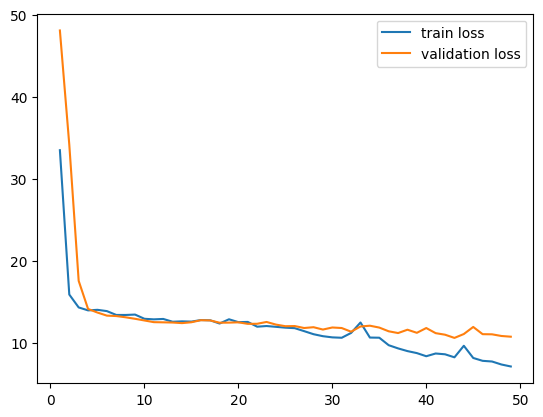

In [29]:
vec_losses = losses[["epoch", "tr_mae", "val_mae"]].values

plt.plot(vec_losses[:, 0], vec_losses[:, 1], label="train loss")
plt.plot(vec_losses[:, 0], vec_losses[:, 2], label="validation loss")
plt.legend()
plt.show()

Our model can't reach a lower validation loss after 20/30 epochs, and it plateaues at around 13 mae. Instead, training is going down, which means it is adapting to the dataset. However, the training loss seems erratic after a certain epoch. Can we make an educated guess on why this is the case?

One first educated guess is that we can fit training set but NOT validation. In fact, validation plateaues, while training keeps lowering.
A possible approach is to make the network more "generalisable". To do so, we can apply little modifications.

In [22]:
class Dropout3DCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 8, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(8)
        self.conv2 = nn.Conv3d(8, 16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(16)
        self.pool1 = nn.MaxPool3d(2)
        self.pool2 = nn.AdaptiveAvgPool3d(1)
        self.fc1 = nn.Linear(16, 64)
        self.dropout = nn.Dropout(0.3) # We add a Dropout layer for enhanced generalibility
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x: th.Tensor):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        out = self.fc2(x)
        return out

network = Dropout3DCNN().to(device=device)
optimizer = th.optim.AdamW(network.parameters(), lr=1e-3)
loss_fn = nn.L1Loss() # We are interested to minimise the MAE

In [39]:
best_val_mae = np.inf

curr_epoch = 0
latest_epoch = 0

train_dl, val_dl = get_loaders()

losses = pd.DataFrame(columns=["epoch", "tr_mae", "val_mae"])
if os.path.exists("../checkpoints/Dropout3DCNN_best_model.pth"):
    state_dict = th.load("../checkpoints/Dropout3DCNN_best_model.pth", weights_only=False)
    curr_epoch = state_dict["epoch"]
    best_val_mae = state_dict["best_val_mae"]
    network.load_state_dict(state_dict["model_state_dict"])
    optimizer.load_state_dict(state_dict["optimizer_state_dict"])
    losses = pd.read_csv("../results/Dropout3DCNN_results.csv")
    latest_epoch = losses["epoch"].max()
    losses = losses[losses["epoch"] <= curr_epoch]

for epoch in range(latest_epoch+1, 100):
    tr_loss = train_epoch(network, train_dl, optimizer)
    val_mae, val_std = eval_model(network, val_dl)
    print(f'Epoch {epoch+1}: train loss {tr_loss:.3f}, val MAE {val_mae:.3f} ± {val_std:.3f}')
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        print(f"New lowest reached: {best_val_mae:.3f}. Saving checkpoint")
        checkpoint = {
            'epoch': epoch,                         # last epoch
            'model_state_dict': network.state_dict(), # model parameters
            'optimizer_state_dict': optimizer.state_dict(),  # optimizer state
            'best_val_mae': best_val_mae
        }
        os.makedirs("../checkpoints", exist_ok=True)
        th.save(checkpoint, f'../checkpoints/Dropout3DCNN_best_model.pth')
    losses.loc[len(losses)] = {"tr_mae": tr_loss, "val_mae": val_mae, "epoch": epoch}
    os.makedirs("../results", exist_ok=True)
    losses.to_csv("../results/Dropout3DCNN_results.csv", index=False)

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:02<00:03,  1.17it/s]


KeyboardInterrupt: 

In [41]:
if os.path.exists("../checkpoints/Dropout3DCNN_best_model.pth"):
    state_dict = th.load("../checkpoints/Dropout3DCNN_best_model.pth", weights_only=False)
    curr_epoch = state_dict["epoch"]
    best_val_mae = state_dict["best_val_mae"]
    network.load_state_dict(state_dict["model_state_dict"])
    optimizer.load_state_dict(state_dict["optimizer_state_dict"])
    losses = pd.read_csv("../results/Dropout3DCNN_results.csv")

In [42]:
test_ds = MRIDataset(
    test_set,
    transform=transforms
)

test_dl = DataLoader(test_ds, batch_size=12,
                        num_workers=0,
                        pin_memory=True,
                        persistent_workers=False,
                        prefetch_factor=None)

test_mae, test_std = eval_model(network, test_dl)
print(f'Test MAE {test_mae:.3f} ± {test_std:.3f}')

Test MAE 16.820 ± 8.141


We see that we already reached a reasonable improvement!

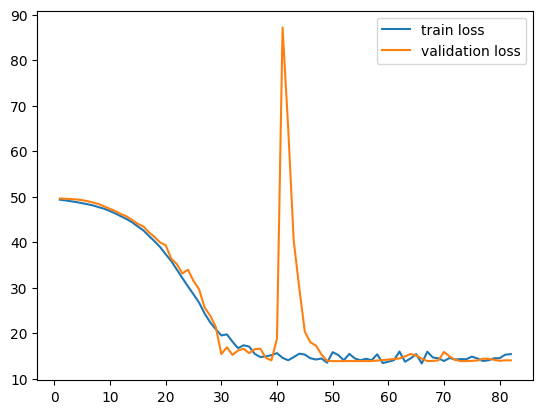

In [43]:
vec_losses = losses[["epoch", "tr_mae", "val_mae"]].values

plt.plot(vec_losses[:, 0], vec_losses[:, 1], label="train loss")
plt.plot(vec_losses[:, 0], vec_losses[:, 2], label="validation loss")
plt.legend()
plt.show()

Despite the sudden spike, just adding the dropout allowed us to reach a better result, but we see the first problems of our network finally showing up. As we can see, the validation and training losses are becoming comparable and they are reaching a common plateau. However, this could _not_ be due to the limitation of the network, but still justifiable with the training behaviour. To get a clear glimpse of what it is happening, it is important to consider how the network is training.

Remember that we train a generic CNN via _gradient descent_ algorithm. Mathematically speaking, we are doing the following:

$\theta \leftarrow \theta - \eta \, \nabla_{\theta} \mathcal{L}(y, \hat{y})$

where $\theta$ are the parameters of the CNN. If the gradients are too high, what happens is that our network creates updates that traverse the loss landscape too boldly. This may translate to the plateau we see. To understand if this is the case, let's take a lot at the gradient of our training. Let's add 2 parameters:
- a scheduler to module the learning rate
- an option to plot the norm of the gradients

In [20]:
def grad_norm(model):
    """Compute total L2 norm of gradients over all parameters."""
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2).item()
            total_norm += param_norm ** 2
    return total_norm ** 0.5

def train_epoch(model, loader, optimizer, update=True, log_norm=False, scheduler=None):
    model.train()
    running = 0.0

    if log_norm:
      grad_norm_sum = 0.0
      grad_norm_count = 0
      max_grad_norm = 0.0

    for batch in tqdm.tqdm(loader):
        img = batch["t1n"].to(device)
        age = batch["age"].to(device).view(-1, 1)
        pred = model(img).view(-1, 1)
        loss = loss_fn(pred, age)
        optimizer.zero_grad()
        loss.backward()

        if update:
          optimizer.step()

        else:
          loss = loss.detach()
        running += loss.item() * img.size(0)

        if log_norm:
            gn = grad_norm(model)
            grad_norm_sum += gn
            grad_norm_count += 1
            if gn > max_grad_norm:
                max_grad_norm = gn
        
    for param_group in optimizer.param_groups:
      print("Learning Rate:", param_group['lr'])
    if log_norm and grad_norm_count > 0:
        avg_grad_norm = grad_norm_sum / grad_norm_count
        print(f"Average grad norm={avg_grad_norm:.6f}  Maximum value={max_grad_norm:.6f}")
    if update:
        if scheduler is not None:
          if isinstance(scheduler, th.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(loss)
          else:
            scheduler.step()

    return running / len(loader.dataset)

First, let's check the effect of the gradient

In [45]:
train_dl, val_dl = get_loaders()
train_epoch(network, train_dl, optimizer, update=False, log_norm=True)

100%|██████████| 7/7 [00:03<00:00,  1.95it/s]

Learning Rate: 0.001
Average grad norm=11.151133  Maximum value=36.433015


14.582165465062978

As we can see, an huge gradient is computed, which may be the culprit of our problem. Before jumping to tune the learning rate, we can actually already infer what is happening. Do we remember how we were considering the age range?

In [57]:
train_dl.dataset[0]

{'t1n': metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           .

The age is a _raw_ number! Practically what happens is that our network is working on a gradient that is extremely high BECAUSE the loss is computed on a raw number! Thus, when we calculate the gradient $|y - \hat{y}|$ we get an high value, especially when the difference is quite high. Something must be modified. let's rewrite our loaders to take into account this.

In [9]:
# for train_idx, val_idx in skf.split(train_set, internal_df["stratify_key"].values):
def get_loaders(transforms, age_transforms):
    ds_tr = MRIDataset(
        train_set.iloc[train_idx],
        transform=transforms,
        age_transforms=age_transforms
    )
    ds_val = MRIDataset(
        train_set.iloc[val_idx],
        transform=transforms,
        age_transforms=age_transforms
    )
    train_dl = DataLoader(ds_tr, batch_size=16,
                            shuffle=True,
                            num_workers=2,
                            pin_memory=False,
                            persistent_workers=True,
                            prefetch_factor=None)
                            # persistent_workers=True,
                            # prefetch_factor=2)
    val_dl = DataLoader(ds_val, batch_size=16,
                            num_workers=2,
                            pin_memory=False,
                            persistent_workers=True,
                            prefetch_factor=None)
                            # persistent_workers=True,
                            # prefetch_factor=2)

    return train_dl, val_dl

In [10]:
age_transforms = lambda x: x / 100. # We suppose the maximum age is 100!

Another important thing to consider is that we are computing the gradients using the MAE objective. Let's take a look to the graph of the MAE gradients and values

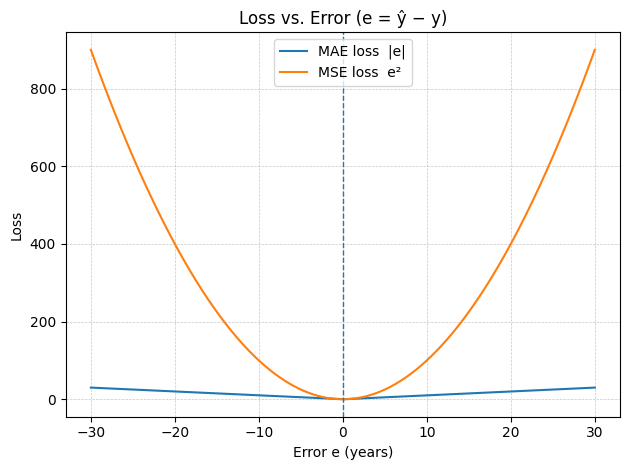

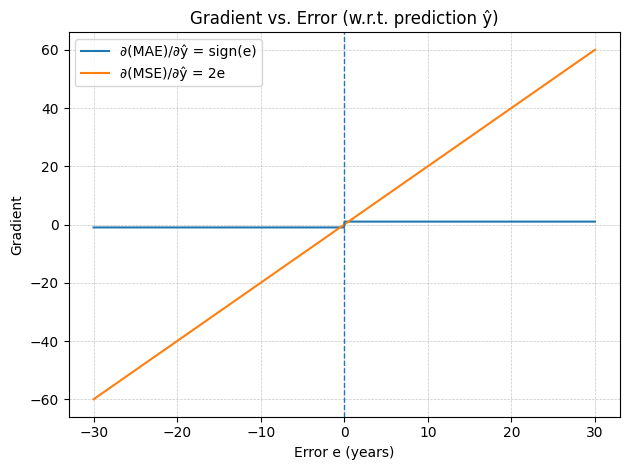

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Error range: prediction error e = y_hat - y (in years)
e = np.linspace(-30, 30, 2001)

# Losses
mae = np.abs(e)
mse = e**2

# Gradients w.r.t. y_hat
# For MSE: d/dy_hat (e^2) = 2e
grad_mse = 2 * e

# For MAE: d/dy_hat |e| = sign(e); non-differentiable in 0
grad_mae = np.sign(e)
grad_mae[np.isclose(e, 0.0)] = 0.0

plt.figure()
plt.plot(e, mae, label="MAE loss  |e|")
plt.plot(e, mse, label="MSE loss  e²")
plt.axvline(0, linestyle="--", linewidth=1)
plt.title("Loss vs. Error (e = ŷ − y)")
plt.xlabel("Error e (years)")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(e, grad_mae, label="∂(MAE)/∂ŷ = sign(e)")
plt.plot(e, grad_mse, label="∂(MSE)/∂ŷ = 2e")
plt.axvline(0, linestyle="--", linewidth=1)
plt.title("Gradient vs. Error (w.r.t. prediction ŷ)")
plt.xlabel("Error e (years)")
plt.ylabel("Gradient")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

Remember that the chain rule for training our network is the following:

$\frac{\partial L}{\partial w} = \frac{\partial L}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial w}$

$\frac{\partial L}{\partial \hat{y}}$ is what we plotted. We can see that for MAE it remains -1 or 1 giving only the direction of the error. For MSE, it gives an additional penalty proportional to the error we commit. Gradient will be also smoother, which furtherly justifies its utilisation.

Let's try now to apply these modifications.

In [11]:
# Modify the eval model function to express the age difference 
def eval_model(model, loader, loss_fns={}):
    model.eval()
    with th.no_grad():
        losses = {k:[] for k in loss_fns.keys()}
        for batch in loader:
            img = batch["t1n"].to(device)
            age = batch["age"].to(device).view(-1, 1)
            pred = model(img).view(-1, 1)
            for k in loss_fns.keys():
                losses[k].append(loss_fns[k](pred, age).cpu().numpy())
        losses = {k: np.concatenate(val) for k, val in losses.items()}
    return {k: {"mean": np.mean(val), "std": np.std(val)} for k, val in losses.items()}

In [26]:
network = Dropout3DCNN().to(device=device)
optimizer = th.optim.AdamW(network.parameters(), lr=1e-3)
loss_fn = nn.MSELoss() # Switch to MSE 
scheduler = None # For now we ignore the scheduler

best_val_mae = np.inf
curr_epoch = -1
latest_epoch = -1
train_dl, val_dl = get_loaders(transforms=transforms, age_transforms=age_transforms)

losses = pd.DataFrame()
if os.path.exists("../checkpoints/Dropout3DCNN_best_model_norm_age.pth"):
    state_dict = th.load("../checkpoints/Dropout3DCNN_best_model_norm_age.pth", weights_only=False)
    curr_epoch = state_dict["epoch"]
    best_val_mae = state_dict["best_val_mae"]
    network.load_state_dict(state_dict["model_state_dict"])
    optimizer.load_state_dict(state_dict["optimizer_state_dict"])
    scheduler.last_epoch = curr_epoch
    losses = pd.read_csv("../results/Dropout3DCNN_results_norm_age.csv")
    latest_epoch = losses["epoch"].max()
    losses = losses[losses["epoch"] <= curr_epoch]

for epoch in range(latest_epoch+1, 100):
    tr_loss = train_epoch(network, train_dl, optimizer, update=True, log_norm=True, scheduler=scheduler)
    val_losses = eval_model(network, val_dl, loss_fns={
        "mse": nn.MSELoss(reduction='none'), "mae": lambda pred, age: th.abs(pred-age)*100
    })
    print(f"Epoch {epoch+1}: train loss {tr_loss:.3f}, val MAE {val_losses['mae']['mean']:.3f} ± {val_losses['mae']['std']:.3f}")
    if val_losses['mae']['mean'] < best_val_mae:
        best_val_mae = val_losses['mae']['mean']
        print(f"New lowest reached: {best_val_mae:.3f}. Saving checkpoint")
        checkpoint = {
            'epoch': epoch,                         # last epoch
            'model_state_dict': network.state_dict(), # model parameters
            'optimizer_state_dict': optimizer.state_dict(),  # optimizer state
            'best_val_mae': best_val_mae
        }
        os.makedirs("../checkpoints", exist_ok=True)
        th.save(checkpoint, f'../checkpoints/Dropout3DCNN_best_model_norm_age.pth')
    losses = pd.concat([losses, pd.DataFrame([{"tr_mse": tr_loss, "epoch": epoch, **{f"val_{k}": val['mean'].item() for k,val in val_losses.items()}}])])
    os.makedirs("../results", exist_ok=True)
    losses.to_csv("../results/Dropout3DCNN_results_norm_age.csv", index=False)

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:09<00:00,  1.41s/it]

Learning Rate: 0.001
Average grad norm=2.295571  Maximum value=2.754316



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa98470beb0>
Traceback (most recent call last):
  File "/home/fsammarco/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/fsammarco/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  File "/home/afrotscher/miniconda3/envs/myenv/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa98470beb0>
Traceback (most recent call last):
  File "/home/fsammarco/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/fsammarco/.local/lib/python3.10/site-packages/torch/utils/data/dat

Epoch 1: train loss 0.246, val MAE 39.497 ± 16.291
New lowest reached: 39.497. Saving checkpoint


100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


Learning Rate: 0.001
Average grad norm=1.189933  Maximum value=1.665036
Epoch 2: train loss 0.106, val MAE 31.829 ± 16.428
New lowest reached: 31.829. Saving checkpoint


100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


Learning Rate: 0.001
Average grad norm=0.696354  Maximum value=1.194450
Epoch 3: train loss 0.048, val MAE 24.179 ± 15.766
New lowest reached: 24.179. Saving checkpoint


100%|██████████| 7/7 [00:03<00:00,  2.00it/s]


Learning Rate: 0.001
Average grad norm=0.312214  Maximum value=0.704884
Epoch 4: train loss 0.037, val MAE 21.479 ± 14.585
New lowest reached: 21.479. Saving checkpoint


 14%|█▍        | 1/7 [00:00<00:05,  1.01it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa98470beb0>
Traceback (most recent call last):
  File "/home/fsammarco/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa98470beb0>self._shutdown_workers()

  File "/home/fsammarco/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Traceback (most recent call last):
  File "/home/fsammarco/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        if w.is_alive():
  File "/home/afrotscher/miniconda3/envs/myenv/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
self._shutdown_workers()
  File "/home/fsammarco/.local/lib/p

Learning Rate: 0.001
Average grad norm=0.235470  Maximum value=0.397672
Epoch 5: train loss 0.035, val MAE 19.418 ± 13.280
New lowest reached: 19.418. Saving checkpoint


100%|██████████| 7/7 [00:03<00:00,  2.02it/s]


Learning Rate: 0.001
Average grad norm=0.328655  Maximum value=0.669737
Epoch 6: train loss 0.032, val MAE 17.497 ± 11.601
New lowest reached: 17.497. Saving checkpoint


100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


Learning Rate: 0.001
Average grad norm=0.324669  Maximum value=1.214037
Epoch 7: train loss 0.036, val MAE 16.860 ± 10.967
New lowest reached: 16.860. Saving checkpoint


100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


Learning Rate: 0.001
Average grad norm=0.325271  Maximum value=0.461742
Epoch 8: train loss 0.033, val MAE 17.562 ± 11.652


100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


Learning Rate: 0.001
Average grad norm=0.266451  Maximum value=0.556121
Epoch 9: train loss 0.035, val MAE 15.848 ± 9.879
New lowest reached: 15.848. Saving checkpoint


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


Learning Rate: 0.001
Average grad norm=0.366702  Maximum value=0.936369
Epoch 10: train loss 0.035, val MAE 15.096 ± 8.878
New lowest reached: 15.096. Saving checkpoint


100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


Learning Rate: 0.001
Average grad norm=0.227421  Maximum value=0.276671
Epoch 11: train loss 0.040, val MAE 14.542 ± 8.112
New lowest reached: 14.542. Saving checkpoint


100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


Learning Rate: 0.001
Average grad norm=0.315046  Maximum value=1.179538
Epoch 12: train loss 0.029, val MAE 14.244 ± 7.799
New lowest reached: 14.244. Saving checkpoint


100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


Learning Rate: 0.001
Average grad norm=0.260764  Maximum value=0.493252
Epoch 13: train loss 0.038, val MAE 14.101 ± 7.740
New lowest reached: 14.101. Saving checkpoint


100%|██████████| 7/7 [00:03<00:00,  1.98it/s]


Learning Rate: 0.001
Average grad norm=0.370922  Maximum value=1.250192
Epoch 14: train loss 0.035, val MAE 14.233 ± 7.930


100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


Learning Rate: 0.001
Average grad norm=0.301469  Maximum value=0.545317
Epoch 15: train loss 0.030, val MAE 13.907 ± 7.809
New lowest reached: 13.907. Saving checkpoint


100%|██████████| 7/7 [00:03<00:00,  1.98it/s]


Learning Rate: 0.001
Average grad norm=0.344647  Maximum value=0.725631
Epoch 16: train loss 0.034, val MAE 13.952 ± 7.668


100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


Learning Rate: 0.001
Average grad norm=0.311617  Maximum value=1.086540
Epoch 17: train loss 0.031, val MAE 13.890 ± 7.609
New lowest reached: 13.890. Saving checkpoint


100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


Learning Rate: 0.001
Average grad norm=0.283650  Maximum value=0.514782
Epoch 18: train loss 0.029, val MAE 13.698 ± 7.934
New lowest reached: 13.698. Saving checkpoint


100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


Learning Rate: 0.001
Average grad norm=0.213332  Maximum value=0.314614
Epoch 19: train loss 0.030, val MAE 13.962 ± 7.746


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


Learning Rate: 0.001
Average grad norm=0.195558  Maximum value=0.526361
Epoch 20: train loss 0.033, val MAE 14.099 ± 7.983


100%|██████████| 7/7 [00:03<00:00,  1.97it/s]


Learning Rate: 0.001
Average grad norm=0.213927  Maximum value=0.411364
Epoch 21: train loss 0.030, val MAE 13.605 ± 7.513
New lowest reached: 13.605. Saving checkpoint


100%|██████████| 7/7 [00:03<00:00,  1.98it/s]


Learning Rate: 0.001
Average grad norm=0.339978  Maximum value=0.881614
Epoch 22: train loss 0.033, val MAE 13.586 ± 7.467
New lowest reached: 13.586. Saving checkpoint


100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


Learning Rate: 0.001
Average grad norm=0.346374  Maximum value=1.188399
Epoch 23: train loss 0.031, val MAE 14.147 ± 8.247


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


Learning Rate: 0.001
Average grad norm=0.191701  Maximum value=0.362917
Epoch 24: train loss 0.031, val MAE 13.407 ± 7.450
New lowest reached: 13.407. Saving checkpoint


100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


Learning Rate: 0.001
Average grad norm=0.214581  Maximum value=0.420645
Epoch 25: train loss 0.032, val MAE 13.379 ± 7.425
New lowest reached: 13.379. Saving checkpoint


100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


Learning Rate: 0.001
Average grad norm=0.256672  Maximum value=0.501121
Epoch 26: train loss 0.031, val MAE 13.476 ± 7.486


100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


Learning Rate: 0.001
Average grad norm=0.306201  Maximum value=0.893920
Epoch 27: train loss 0.023, val MAE 13.190 ± 7.674
New lowest reached: 13.190. Saving checkpoint


100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


Learning Rate: 0.001
Average grad norm=0.201994  Maximum value=0.340507
Epoch 28: train loss 0.028, val MAE 13.160 ± 7.639
New lowest reached: 13.160. Saving checkpoint


100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


Learning Rate: 0.001
Average grad norm=0.353340  Maximum value=1.015636
Epoch 29: train loss 0.033, val MAE 13.100 ± 7.410
New lowest reached: 13.100. Saving checkpoint


100%|██████████| 7/7 [00:03<00:00,  1.97it/s]


Learning Rate: 0.001
Average grad norm=0.220717  Maximum value=0.455472
Epoch 30: train loss 0.029, val MAE 13.129 ± 7.320


100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


Learning Rate: 0.001
Average grad norm=0.225287  Maximum value=0.544571
Epoch 31: train loss 0.026, val MAE 13.537 ± 7.648


100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


Learning Rate: 0.001
Average grad norm=0.241991  Maximum value=0.570101
Epoch 32: train loss 0.027, val MAE 13.112 ± 7.272


100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


Learning Rate: 0.001
Average grad norm=0.243025  Maximum value=0.386016
Epoch 33: train loss 0.027, val MAE 13.068 ± 7.279
New lowest reached: 13.068. Saving checkpoint


100%|██████████| 7/7 [00:03<00:00,  1.98it/s]


Learning Rate: 0.001
Average grad norm=0.177538  Maximum value=0.491362
Epoch 34: train loss 0.025, val MAE 12.896 ± 7.282
New lowest reached: 12.896. Saving checkpoint


100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


Learning Rate: 0.001
Average grad norm=0.201063  Maximum value=0.508812
Epoch 35: train loss 0.025, val MAE 12.835 ± 7.235
New lowest reached: 12.835. Saving checkpoint


100%|██████████| 7/7 [00:03<00:00,  1.97it/s]


Learning Rate: 0.001
Average grad norm=0.184342  Maximum value=0.239125
Epoch 36: train loss 0.027, val MAE 12.948 ± 7.176


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


Learning Rate: 0.001
Average grad norm=0.368134  Maximum value=1.473298
Epoch 37: train loss 0.025, val MAE 13.071 ± 7.305


100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


Learning Rate: 0.001
Average grad norm=0.335494  Maximum value=0.765912
Epoch 38: train loss 0.031, val MAE 14.224 ± 8.618


100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


Learning Rate: 0.001
Average grad norm=0.337078  Maximum value=1.010243
Epoch 39: train loss 0.026, val MAE 13.261 ± 7.975


100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


Learning Rate: 0.001
Average grad norm=0.248870  Maximum value=0.901141
Epoch 40: train loss 0.021, val MAE 13.317 ± 7.767


100%|██████████| 7/7 [00:03<00:00,  1.97it/s]


Learning Rate: 0.001
Average grad norm=0.248109  Maximum value=0.423356
Epoch 41: train loss 0.030, val MAE 13.762 ± 9.665


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Learning Rate: 0.001
Average grad norm=0.286815  Maximum value=0.503351
Epoch 42: train loss 0.029, val MAE 13.435 ± 8.051


100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Learning Rate: 0.001
Average grad norm=0.229956  Maximum value=0.443850
Epoch 43: train loss 0.029, val MAE 13.881 ± 7.921


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


Learning Rate: 0.001
Average grad norm=0.223259  Maximum value=0.605823
Epoch 44: train loss 0.022, val MAE 13.473 ± 7.845


100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


Learning Rate: 0.001
Average grad norm=0.215905  Maximum value=0.538376
Epoch 45: train loss 0.033, val MAE 13.612 ± 7.818


100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


Learning Rate: 0.001
Average grad norm=0.130420  Maximum value=0.181121
Epoch 46: train loss 0.021, val MAE 14.205 ± 8.519


100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


Learning Rate: 0.001
Average grad norm=0.258518  Maximum value=0.403851
Epoch 47: train loss 0.029, val MAE 14.048 ± 8.299


100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


Learning Rate: 0.001
Average grad norm=0.216693  Maximum value=0.330057
Epoch 48: train loss 0.026, val MAE 13.340 ± 7.719


100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


Learning Rate: 0.001
Average grad norm=0.200419  Maximum value=0.479011
Epoch 49: train loss 0.027, val MAE 13.695 ± 7.921


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


Learning Rate: 0.001
Average grad norm=0.188220  Maximum value=0.294305
Epoch 50: train loss 0.026, val MAE 14.335 ± 10.329


100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


Learning Rate: 0.001
Average grad norm=0.168398  Maximum value=0.477445
Epoch 51: train loss 0.029, val MAE 14.037 ± 9.478


100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


Learning Rate: 0.001
Average grad norm=0.274420  Maximum value=0.860770
Epoch 52: train loss 0.028, val MAE 17.286 ± 11.624


100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


Learning Rate: 0.001
Average grad norm=0.214350  Maximum value=0.333898
Epoch 53: train loss 0.028, val MAE 15.878 ± 10.349


100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Learning Rate: 0.001
Average grad norm=0.256801  Maximum value=0.911542
Epoch 54: train loss 0.027, val MAE 14.017 ± 8.086


100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


Learning Rate: 0.001
Average grad norm=0.300306  Maximum value=1.050445
Epoch 55: train loss 0.029, val MAE 13.895 ± 7.925


100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


Learning Rate: 0.001
Average grad norm=0.210149  Maximum value=0.399753
Epoch 56: train loss 0.031, val MAE 13.434 ± 7.862


100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


Learning Rate: 0.001
Average grad norm=0.212421  Maximum value=0.372014
Epoch 57: train loss 0.028, val MAE 13.651 ± 7.781


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


Learning Rate: 0.001
Average grad norm=0.255511  Maximum value=0.793375
Epoch 58: train loss 0.028, val MAE 14.013 ± 8.093


100%|██████████| 7/7 [00:03<00:00,  1.97it/s]


Learning Rate: 0.001
Average grad norm=0.225028  Maximum value=0.648309
Epoch 59: train loss 0.030, val MAE 15.135 ± 9.536


100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


Learning Rate: 0.001
Average grad norm=0.239803  Maximum value=0.435128
Epoch 60: train loss 0.029, val MAE 13.833 ± 7.890


100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


Learning Rate: 0.001
Average grad norm=0.293231  Maximum value=1.049059
Epoch 61: train loss 0.027, val MAE 13.827 ± 7.886


100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


Learning Rate: 0.001
Average grad norm=0.165914  Maximum value=0.241729
Epoch 62: train loss 0.031, val MAE 14.767 ± 9.154


100%|██████████| 7/7 [00:03<00:00,  1.97it/s]


Learning Rate: 0.001
Average grad norm=0.283105  Maximum value=0.452376
Epoch 63: train loss 0.031, val MAE 14.259 ± 8.516


100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


Learning Rate: 0.001
Average grad norm=0.260455  Maximum value=0.678972
Epoch 64: train loss 0.028, val MAE 13.544 ± 7.742


100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


Learning Rate: 0.001
Average grad norm=0.171855  Maximum value=0.303166
Epoch 65: train loss 0.025, val MAE 13.822 ± 7.935


100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


Learning Rate: 0.001
Average grad norm=0.181374  Maximum value=0.505004
Epoch 66: train loss 0.026, val MAE 13.791 ± 7.896


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


Learning Rate: 0.001
Average grad norm=0.273317  Maximum value=0.763278
Epoch 67: train loss 0.028, val MAE 13.490 ± 7.696


100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


Learning Rate: 0.001
Average grad norm=0.206757  Maximum value=0.329482
Epoch 68: train loss 0.027, val MAE 14.154 ± 8.440


100%|██████████| 7/7 [00:03<00:00,  2.03it/s]


Learning Rate: 0.001
Average grad norm=0.223083  Maximum value=0.411665
Epoch 69: train loss 0.027, val MAE 15.417 ± 9.886


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


Learning Rate: 0.001
Average grad norm=0.206895  Maximum value=0.363327
Epoch 70: train loss 0.026, val MAE 14.140 ± 8.532


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


Learning Rate: 0.001
Average grad norm=0.163551  Maximum value=0.309445
Epoch 71: train loss 0.026, val MAE 13.977 ± 8.399


100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


Learning Rate: 0.001
Average grad norm=0.281411  Maximum value=0.573369
Epoch 72: train loss 0.025, val MAE 13.248 ± 7.595


100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


Learning Rate: 0.001
Average grad norm=0.204065  Maximum value=0.577656
Epoch 73: train loss 0.028, val MAE 14.171 ± 10.614


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


Learning Rate: 0.001
Average grad norm=0.325590  Maximum value=1.064285
Epoch 74: train loss 0.028, val MAE 29.204 ± 16.588


100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


Learning Rate: 0.001
Average grad norm=0.166388  Maximum value=0.468879
Epoch 75: train loss 0.026, val MAE 14.390 ± 10.241


100%|██████████| 7/7 [00:03<00:00,  1.98it/s]


Learning Rate: 0.001
Average grad norm=0.216405  Maximum value=0.447023
Epoch 76: train loss 0.030, val MAE 13.645 ± 7.794


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


Learning Rate: 0.001
Average grad norm=0.214639  Maximum value=0.268457
Epoch 77: train loss 0.026, val MAE 13.486 ± 8.345


100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


Learning Rate: 0.001
Average grad norm=0.171669  Maximum value=0.438703
Epoch 78: train loss 0.023, val MAE 13.438 ± 8.508


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


Learning Rate: 0.001
Average grad norm=0.232842  Maximum value=0.477959
Epoch 79: train loss 0.025, val MAE 13.464 ± 7.703


100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


Learning Rate: 0.001
Average grad norm=0.231679  Maximum value=0.552357
Epoch 80: train loss 0.029, val MAE 14.074 ± 8.352


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


Learning Rate: 0.001
Average grad norm=0.289712  Maximum value=0.863735
Epoch 81: train loss 0.025, val MAE 13.362 ± 7.706


100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


Learning Rate: 0.001
Average grad norm=0.157855  Maximum value=0.406150
Epoch 82: train loss 0.022, val MAE 13.237 ± 8.364


100%|██████████| 7/7 [00:03<00:00,  2.02it/s]


Learning Rate: 0.001
Average grad norm=0.262807  Maximum value=0.427789
Epoch 83: train loss 0.032, val MAE 13.249 ± 7.732


100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


Learning Rate: 0.001
Average grad norm=0.206289  Maximum value=0.385439
Epoch 84: train loss 0.027, val MAE 14.005 ± 8.330


100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


Learning Rate: 0.001
Average grad norm=0.190831  Maximum value=0.367551
Epoch 85: train loss 0.024, val MAE 13.655 ± 7.870


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


Learning Rate: 0.001
Average grad norm=0.161438  Maximum value=0.445235
Epoch 86: train loss 0.025, val MAE 13.398 ± 7.689


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


Learning Rate: 0.001
Average grad norm=0.251308  Maximum value=0.885278
Epoch 87: train loss 0.028, val MAE 13.641 ± 7.897


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


Learning Rate: 0.001
Average grad norm=0.233679  Maximum value=0.383508
Epoch 88: train loss 0.027, val MAE 13.617 ± 7.893


100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


Learning Rate: 0.001
Average grad norm=0.202221  Maximum value=0.508912
Epoch 89: train loss 0.028, val MAE 13.313 ± 7.653


100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


Learning Rate: 0.001
Average grad norm=0.205223  Maximum value=0.395490
Epoch 90: train loss 0.026, val MAE 13.112 ± 8.232


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


Learning Rate: 0.001
Average grad norm=0.244456  Maximum value=0.368796
Epoch 91: train loss 0.028, val MAE 13.218 ± 7.629


100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


Learning Rate: 0.001
Average grad norm=0.242142  Maximum value=0.657500
Epoch 92: train loss 0.025, val MAE 13.933 ± 8.341


100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


Learning Rate: 0.001
Average grad norm=0.329207  Maximum value=0.945111
Epoch 93: train loss 0.028, val MAE 13.326 ± 7.694


100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


Learning Rate: 0.001
Average grad norm=0.271862  Maximum value=0.951983
Epoch 94: train loss 0.027, val MAE 14.556 ± 9.113


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


Learning Rate: 0.001
Average grad norm=0.238028  Maximum value=0.894810
Epoch 95: train loss 0.026, val MAE 13.267 ± 7.702


100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


Learning Rate: 0.001
Average grad norm=0.169175  Maximum value=0.363583
Epoch 96: train loss 0.026, val MAE 12.793 ± 7.868
New lowest reached: 12.793. Saving checkpoint


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


Learning Rate: 0.001
Average grad norm=0.281517  Maximum value=0.704718
Epoch 97: train loss 0.029, val MAE 14.433 ± 9.063


100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


Learning Rate: 0.001
Average grad norm=0.323747  Maximum value=1.115059
Epoch 98: train loss 0.024, val MAE 13.211 ± 7.773


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Learning Rate: 0.001
Average grad norm=0.163178  Maximum value=0.250215
Epoch 99: train loss 0.025, val MAE 15.353 ± 9.939


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


Learning Rate: 0.001
Average grad norm=0.208442  Maximum value=0.521173
Epoch 100: train loss 0.029, val MAE 13.586 ± 8.022


In [27]:
network = Dropout3DCNN().to(device=device)
losses = pd.DataFrame()
if os.path.exists("../checkpoints/Dropout3DCNN_best_model_norm_age.pth"):
    state_dict = th.load("../checkpoints/Dropout3DCNN_best_model_norm_age.pth", weights_only=False)
    curr_epoch = state_dict["epoch"]
    best_val_mae = state_dict["best_val_mae"]
    network.load_state_dict(state_dict["model_state_dict"])
    losses = pd.read_csv("../results/Dropout3DCNN_results_norm_age.csv")

In [28]:
test_ds = MRIDataset(
    test_set,
    transform=transforms,
    age_transforms=age_transforms
)

test_dl = DataLoader(test_ds, batch_size=12,
                        num_workers=0,
                        pin_memory=True,
                        persistent_workers=False,
                        prefetch_factor=None)

test_losses = eval_model(network, test_dl, loss_fns={
        "mse": nn.MSELoss(reduction='none'), "mae": lambda pred, age: th.abs(pred-age)*100
    })
print(f'Test:')
for k, v in test_losses.items():
    print(f'{k}: {v["mean"]:.3f} ± {v["std"]:.3f}')

Test:
mse: 0.030 ± 0.029
mae: 14.970 ± 8.635


Although minor, we again obtained an improvement.
We still encounter though a very high MAE in test. Can we improve?

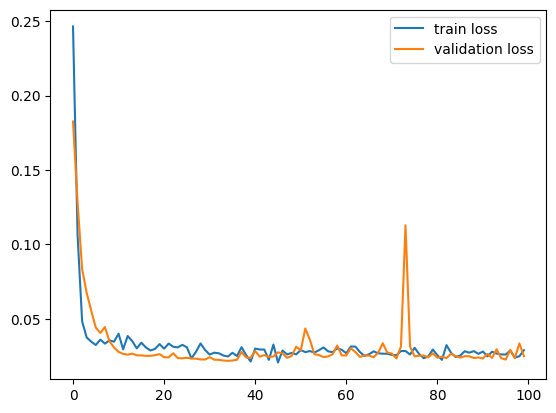

In [30]:
vec_losses = losses[["epoch", "tr_mse", "val_mse"]].values

plt.plot(vec_losses[:, 0], vec_losses[:, 1], label="train loss")
plt.plot(vec_losses[:, 0], vec_losses[:, 2], label="validation loss")
plt.legend()
plt.show()

It's clear we hit a wall now. Test MAE has reached levels comparable to the best MAE on the validation set:

In [29]:
best_val_mae

12.792647

This means that we can't improve with the given model. We obtained a very good base model now that we can improve.
Possible improvements from here are the following:
- Making the architecture more complex
- Tuning properly the learning rate
- Including slight augmentation
We will consider these in the next steps, to wrap up and see if we can improve

# More complex model

Let's start by considering a more complex model. `BatchNorm` is still a valid layer, since batch statistics are manageable given our batch size (16). In your case, if you can't run the model on the GPU, it's better to use `GroupNorm`.

What we can do is:
- Add a dropout on the Convolutional layers, to enhance generalability
- Increase the size of the network 
- Add residual blocks

In [ ]:
class ResBlock3D(nn.Module):
    def __init__(self, c, p_drop=0.0):
        super().__init__()
        self.conv1 = nn.Conv3d(c, c, 3, padding=1, bias=False)
        self.in1   = nn.InstanceNorm3d(c, affine=True)
        self.conv2 = nn.Conv3d(c, c, 3, padding=1, bias=False)
        self.in2   = nn.InstanceNorm3d(c, affine=True)
        self.drop  = nn.Dropout3d(p_drop) if p_drop > 0 else nn.Identity()

    def forward(self, x):
        out = self.drop(F.relu(self.in1(self.conv1(x)), inplace=True))
        out = self.in2(self.conv2(out))
        return F.relu(x + out, inplace=True)

class DownBlock3D(nn.Module):
    def __init__(self, cin, cout, p_drop=0.0):
        super().__init__()
        self.down = nn.Conv3d(cin, cout, kernel_size=3, stride=2, padding=1, bias=False)
        self.in1  = nn.InstanceNorm3d(cout, affine=True)
        self.res  = ResBlock3D(cout, p_drop=p_drop)

    def forward(self, x):
        x = F.relu(self.in1(self.down(x)), inplace=True)
        x = self.res(x)
        return x

class ImprovedAgeNet3D(nn.Module):
    def __init__(self, in_ch=1, base=16, p_drop=0.2):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv3d(in_ch, base, 3, padding=1, bias=False),
            nn.InstanceNorm3d(base, affine=True),
            nn.ReLU(inplace=True),
            ResBlock3D(base, p_drop=p_drop/2),
        )
        self.stage1 = DownBlock3D(base,   base*2, p_drop=p_drop)   # /2
        self.stage2 = DownBlock3D(base*2, base*4, p_drop=p_drop)   # /4
        self.stage3 = DownBlock3D(base*4, base*8, p_drop=p_drop)   # /8
        self.stage4 = DownBlock3D(base*8, base*8, p_drop=p_drop)   # /16

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Flatten(),
            nn.Linear(base*8, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        return self.head(x)

Let's try our model

In [45]:
network = ImprovedAgeNet3D().to(device=device)
with th.no_grad():
    network(train_dl.dataset[0]["t1n"].unsqueeze(0).to(device))

We can also try to make the training matching more closely the objective. Optimising MAE may be suboptimal, but we can use instead the so called _Huber Loss_. The Huber loss is a smooth version of the MAE. Let's visualize it.

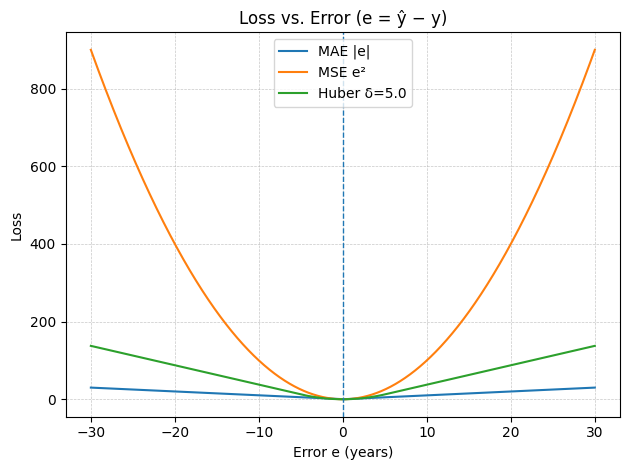

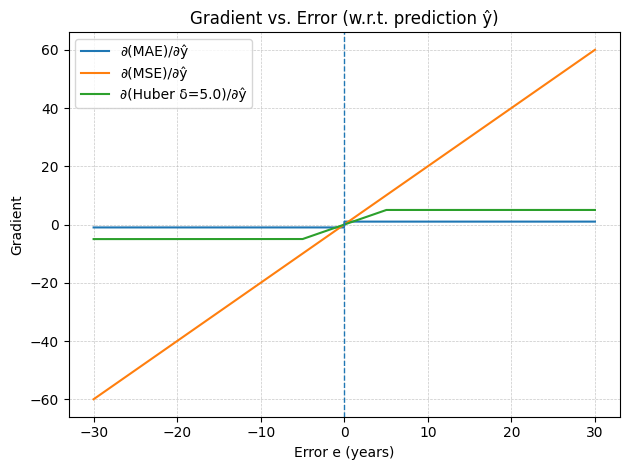

In [45]:
delta = 5.0
huber = np.where(np.abs(e) <= delta, 0.5 * e**2, delta * (np.abs(e) - 0.5 * delta))
grad_huber = np.where(np.abs(e) <= delta, e, delta * np.sign(e))

plt.figure()
plt.plot(e, mae, label="MAE |e|")
plt.plot(e, mse, label="MSE e²")
plt.plot(e, huber, label=f"Huber δ={delta}")
plt.axvline(0, linestyle="--", linewidth=1)
plt.title("Loss vs. Error (e = ŷ − y)")
plt.xlabel("Error e (years)")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(e, grad_mae, label="∂(MAE)/∂ŷ")
plt.plot(e, grad_mse, label="∂(MSE)/∂ŷ")
plt.plot(e, grad_huber, label=f"∂(Huber δ={delta})/∂ŷ")
plt.axvline(0, linestyle="--", linewidth=1)
plt.title("Gradient vs. Error (w.r.t. prediction ŷ)")
plt.xlabel("Error e (years)")
plt.ylabel("Gradient")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

We can see that the behaviour is similar to MSE, but only up to a certain point. This makes the objective more close to MAE.
We will use this loss for our new training. $\delta$ is a value that actually tune the "saturation" point of the gradient. When the difference between the predictions reach that level, functions gradient saturates to $\delta$.

In our case, let's put a simple $\delta = 0.03$ to account for gradient saturation over 3 years difference. We should ideally follow a more rigorous approach however. Can you infer which one?

# Augmentation

We introduce some spicy augmentation in the mix.
We ideally don't want to introduce HEAVY augmentation. This is because in principle we can rely on the fact that all our scans are aligned on the MNI template. This allows us to exploit some regularity in our data. However, it is not uncommon to have registration issues, where the brains are not precisely aligned or they are a bit bigger/smaller than the standard.
For this reason, adding slight augmentation is always a good idea. Let's do it. 

In [13]:
deg = np.deg2rad

train_transformation = mtr.Compose([
    mtr.EnsureChannelFirst(),
    mtr.SpatialCrop(
        roi_start = (6, 2, 0),
        roi_end = (173, 214, 160),
    ),
    mtr.Lambda(lambda x: x/255.),
    mtr.RandAffine( # <- little rotation
        prob=0.5,
        rotate_range=(deg(5), deg(5), deg(5)),     # ±5°
        scale_range=(0.05, 0.05, 0.05),            # ≈ 0.95–1.05
        translate_range=(3, 3, 3),                 # up to 3 voxels
        mode="bilinear",              # image: smooth, label: nearest
    ),
    mtr.RandZoom(
        prob=0.3,
        min_zoom=0.95, max_zoom=1.05,
        mode="trilinear",
        keep_size=True,
    ),
    mtr.RandBiasField(
        prob=0.3, 
        coeff_range=(0.0, 0.1), 
        degree=3),
    mtr.RandShiftIntensity(
        offsets=0.05, 
        prob=0.5
    )
])

val_transformation = mtr.Compose([
    mtr.EnsureChannelFirst(),
    mtr.SpatialCrop(
        roi_start = (6, 2, 0),
        roi_end = (173, 214, 160),
    ),
    mtr.Lambda(lambda x: x/255.)
])

In [14]:
def get_loaders_aug(train_transforms, val_transforms, age_transforms, batch_size=16):
    ds_tr = MRIDataset(
        train_set.iloc[train_idx],
        transform=train_transforms,
        age_transforms=age_transforms
    )
    ds_val = MRIDataset(
        train_set.iloc[val_idx],
        transform=val_transforms,
        age_transforms=age_transforms
    )
    test_ds = MRIDataset(
        test_set,
        transform=val_transforms,
        age_transforms=age_transforms
    )

    train_dl = DataLoader(ds_tr, batch_size=batch_size,
                            shuffle=True,
                            num_workers=6,
                            pin_memory=True,
                            persistent_workers=True,
                            prefetch_factor=2)
    val_dl = DataLoader(ds_val, batch_size=batch_size,
                            num_workers=2,
                            pin_memory=False,
                            persistent_workers=True,
                            prefetch_factor=None)
                            # persistent_workers=True,
                            # prefetch_factor=2)
    test_dl = DataLoader(test_ds, batch_size=12,
                            num_workers=0,
                            pin_memory=True,
                            persistent_workers=False,
                            prefetch_factor=None)

    return train_dl, val_dl, test_dl

Let's test

In [23]:
train_dl, val_dl, test_dl = get_loaders_aug(train_transformation, val_transformation, age_transforms)

In [24]:
b = train_dl.dataset[0]

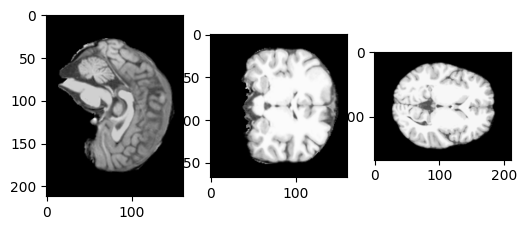

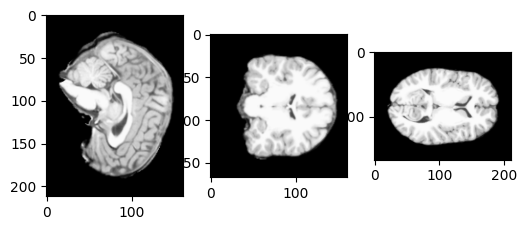

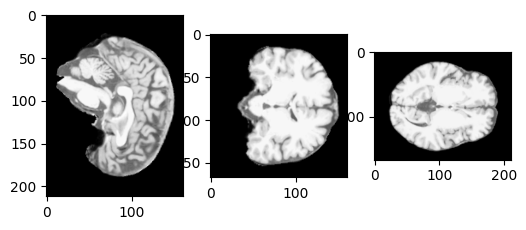

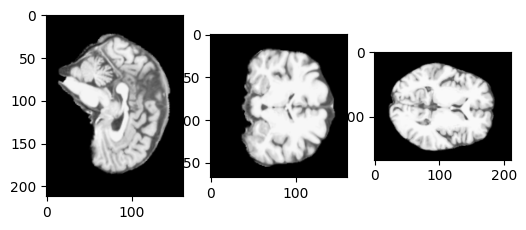

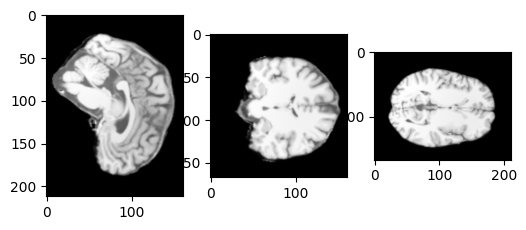

In [25]:
for i in range(5):
    b = train_dl.dataset[i]
    show_brain(b["t1n"])

# Scheduler

We observed that at a certain point loss stagnates.
When this happens, it can also due to the fact that our learning rate is too high or not ideal for our setup.
We can observe that keeping $\lambda = 1e-3$ makes the loss decreasing rapidly, and then stagnates.
This is something not unusual: it means that the model is fast adapting. But this fast adaptation is sometimes destruptive. What we can do is to rely on literature observations. https://arxiv.org/abs/1708.07120 introduced this problem and observed that when a behaviour like that is registered, it may bring the model to a sudden local minima.

`OneCycleLR` in torch proposes a LR scheduler that ramps up the learning rate and gradually decreases it. In this way, we reduce the instability introduced at the start and allow the model to then gradually reach a sweet spot in the loss landscape.

Let's try this out.


Since it is step based, we need to modify the training schedule

In [ ]:
def train_epoch(model, loader, optimizer, loss_fn=None, update=True, log_norm=False, scheduler=None, per_step=False):
    # Add per_step for per_step update of scheduler
    model.train()
    running = 0.0

    if log_norm:
      grad_norm_sum = 0.0
      grad_norm_count = 0
      max_grad_norm = 0.0

    for batch in tqdm.tqdm(loader):
        img = batch["t1n"].to(device)
        age = batch["age"].to(device).view(-1, 1)
        pred = model(img).view(-1, 1)
        loss = loss_fn(pred, age)
        optimizer.zero_grad()
        loss.backward()

        if update:
          optimizer.step()
          if per_step:
             if scheduler is not None:
                if isinstance(scheduler, th.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(loss)
                else:
                    scheduler.step()

        else:
          loss = loss.detach()
        running += loss.item() * img.size(0)

        if log_norm:
            gn = grad_norm(model)
            grad_norm_sum += gn
            grad_norm_count += 1
            if gn > max_grad_norm:
                max_grad_norm = gn
        
    for param_group in optimizer.param_groups:
      print("Learning Rate:", param_group['lr'])
    if log_norm and grad_norm_count > 0:
        avg_grad_norm = grad_norm_sum / grad_norm_count
        print(f"Average grad norm={avg_grad_norm:.6f}  Maximum value={max_grad_norm:.6f}")
    if update:
        if not per_step:
            if scheduler is not None:
                if isinstance(scheduler, th.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(loss)
                else:
                    scheduler.step()

    return running / len(loader.dataset)

Ready to test!

In [39]:
train_dl, val_dl, test_dl = get_loaders_aug(train_transformation, val_transformation, age_transforms, batch_size=2)

network = ImprovedAgeNet3D().to(device=device)
optimizer = th.optim.AdamW(network.parameters(), lr=5e-5)

base_lrs = [g['lr'] for g in optimizer.param_groups]
factors = [5e-5 / b for b in base_lrs]
lambdas = [(lambda f: (lambda _: f))(f) for f in factors]

const = th.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambdas)

scheduler = th.optim.lr_scheduler.SequentialLR(
    optimizer=optimizer,
    schedulers=[th.optim.lr_scheduler.OneCycleLR( # First scheduler
        optimizer,
        max_lr=1e-3,
        total_steps=len(train_dl) * 60,
        pct_start=0.4,                 # 40% warm-up
        anneal_strategy="cos",         # cosine decay
        div_factor=1000.0,               # initial_lr = 1e-3 / 100   = 1e-7
        final_div_factor=50.0,        # final_lr   = 1e-3 / 50 = 5e-5
        cycle_momentum=False
    ),
    const], milestones=[len(train_dl) * 60]
)

delta = 0.03
loss_fn = nn.HuberLoss(delta=delta) # Switch to Huber

best_val_mae = np.inf
curr_epoch = -1

losses = pd.DataFrame()
if os.path.exists("../checkpoints/ImprovedAgeNet3D_best_model.pth"):
    state_dict = th.load("../checkpoints/ImprovedAgeNet3D_best_model.pth", weights_only=False)
    curr_epoch = state_dict["epoch"]
    best_val_mae = state_dict["best_val_mae"]
    network.load_state_dict(state_dict["model_state_dict"])
    optimizer.load_state_dict(state_dict["optimizer_state_dict"])
    losses = pd.read_csv("../results/ImprovedAgeNet3D_results.csv")
    scheduler.last_epoch = curr_epoch * len(train_dl)
    losses = losses[losses["epoch"] <= curr_epoch]
    print(f"Reloaded state from checkpoint (epoch: {curr_epoch})")

for epoch in range(curr_epoch+1, 100):
    tr_loss = train_epoch(network, train_dl, optimizer, loss_fn=loss_fn, update=True, log_norm=True, scheduler=scheduler, per_step=True)
    val_losses = eval_model(network, val_dl, loss_fns={
        "huber": nn.HuberLoss(delta=delta, reduction="none"), "mae": lambda pred, age: th.abs(pred-age)*100
    })
    print(f"Epoch {epoch+1}: train loss {tr_loss:.3f}, val MAE {val_losses['mae']['mean']:.3f} ± {val_losses['mae']['std']:.3f}")
    if val_losses['mae']['mean'] < best_val_mae:
        best_val_mae = val_losses['mae']['mean']
        print(f"New lowest reached: {best_val_mae:.3f}. Saving checkpoint")
        checkpoint = {
            'epoch': epoch,                         # last epoch
            'model_state_dict': network.state_dict(), # model parameters
            'optimizer_state_dict': optimizer.state_dict(),  # optimizer state
            'best_val_mae': best_val_mae
        }
        os.makedirs("../checkpoints", exist_ok=True)
        th.save(checkpoint, f'../checkpoints/ImprovedAgeNet3D_best_model.pth')
    losses = pd.concat([losses, pd.DataFrame([{"tr_huber": tr_loss, "epoch": epoch, **{f"val_{k}": val['mean'].item() for k,val in val_losses.items()}}])])
    os.makedirs("../results", exist_ok=True)
    losses.to_csv("../results/ImprovedAgeNet3D_results.csv", index=False)

Reloaded state from checkpoint (epoch: 61)


100%|██████████| 49/49 [00:16<00:00,  2.91it/s]

Learning Rate: 5e-05
Average grad norm=0.069780  Maximum value=0.142898


Epoch 63: train loss 0.002, val MAE 9.446 ± 6.941


100%|██████████| 49/49 [00:17<00:00,  2.76it/s]


Learning Rate: 5e-05
Average grad norm=0.066144  Maximum value=0.138038
Epoch 64: train loss 0.003, val MAE 9.526 ± 6.959


100%|██████████| 49/49 [00:17<00:00,  2.87it/s]


Learning Rate: 5e-05
Average grad norm=0.079618  Maximum value=0.143799
Epoch 65: train loss 0.002, val MAE 9.681 ± 7.035


100%|██████████| 49/49 [00:17<00:00,  2.86it/s]


Learning Rate: 5e-05
Average grad norm=0.071216  Maximum value=0.162779
Epoch 66: train loss 0.002, val MAE 9.126 ± 7.035


100%|██████████| 49/49 [00:17<00:00,  2.83it/s]


Learning Rate: 5e-05
Average grad norm=0.073733  Maximum value=0.142388
Epoch 67: train loss 0.002, val MAE 9.201 ± 6.751


100%|██████████| 49/49 [00:17<00:00,  2.84it/s]


Learning Rate: 5e-05
Average grad norm=0.069730  Maximum value=0.132292
Epoch 68: train loss 0.002, val MAE 8.956 ± 6.706
New lowest reached: 8.956. Saving checkpoint


100%|██████████| 49/49 [00:16<00:00,  2.92it/s]


Learning Rate: 5e-05
Average grad norm=0.069754  Maximum value=0.138866
Epoch 69: train loss 0.002, val MAE 8.955 ± 6.845
New lowest reached: 8.955. Saving checkpoint


100%|██████████| 49/49 [00:17<00:00,  2.78it/s]


Learning Rate: 5e-05
Average grad norm=0.079540  Maximum value=0.140783
Epoch 70: train loss 0.002, val MAE 8.855 ± 6.729
New lowest reached: 8.855. Saving checkpoint


100%|██████████| 49/49 [00:18<00:00,  2.72it/s]


Learning Rate: 5e-05
Average grad norm=0.084872  Maximum value=0.156373
Epoch 71: train loss 0.002, val MAE 8.933 ± 6.518


100%|██████████| 49/49 [00:17<00:00,  2.86it/s]


Learning Rate: 5e-05
Average grad norm=0.067322  Maximum value=0.145103
Epoch 72: train loss 0.002, val MAE 9.576 ± 7.050


100%|██████████| 49/49 [00:16<00:00,  2.93it/s]


Learning Rate: 5e-05
Average grad norm=0.067697  Maximum value=0.129936
Epoch 73: train loss 0.002, val MAE 8.839 ± 6.700
New lowest reached: 8.839. Saving checkpoint


100%|██████████| 49/49 [00:17<00:00,  2.74it/s]


Learning Rate: 5e-05
Average grad norm=0.078456  Maximum value=0.149652
Epoch 74: train loss 0.002, val MAE 9.755 ± 7.393


100%|██████████| 49/49 [00:17<00:00,  2.77it/s]


Learning Rate: 5e-05
Average grad norm=0.080565  Maximum value=0.164123
Epoch 75: train loss 0.002, val MAE 9.425 ± 6.987


100%|██████████| 49/49 [00:16<00:00,  2.90it/s]


Learning Rate: 5e-05
Average grad norm=0.076212  Maximum value=0.138848
Epoch 76: train loss 0.002, val MAE 8.872 ± 6.694


100%|██████████| 49/49 [00:16<00:00,  2.89it/s]


Learning Rate: 5e-05
Average grad norm=0.070959  Maximum value=0.143591
Epoch 77: train loss 0.002, val MAE 9.494 ± 7.036


100%|██████████| 49/49 [00:17<00:00,  2.83it/s]


Learning Rate: 5e-05
Average grad norm=0.076315  Maximum value=0.156156
Epoch 78: train loss 0.002, val MAE 9.510 ± 7.150


100%|██████████| 49/49 [00:17<00:00,  2.79it/s]


Learning Rate: 5e-05
Average grad norm=0.084306  Maximum value=0.180088
Epoch 79: train loss 0.002, val MAE 8.785 ± 6.626
New lowest reached: 8.785. Saving checkpoint


100%|██████████| 49/49 [00:16<00:00,  2.89it/s]


Learning Rate: 5e-05
Average grad norm=0.081579  Maximum value=0.147091
Epoch 80: train loss 0.002, val MAE 8.832 ± 6.621


100%|██████████| 49/49 [00:16<00:00,  2.89it/s]


Learning Rate: 5e-05
Average grad norm=0.075705  Maximum value=0.152866
Epoch 81: train loss 0.002, val MAE 8.793 ± 6.830


100%|██████████| 49/49 [00:17<00:00,  2.75it/s]


Learning Rate: 5e-05
Average grad norm=0.079758  Maximum value=0.146460
Epoch 82: train loss 0.002, val MAE 9.303 ± 6.997


100%|██████████| 49/49 [00:17<00:00,  2.88it/s]


Learning Rate: 5e-05
Average grad norm=0.072688  Maximum value=0.141775
Epoch 83: train loss 0.002, val MAE 9.112 ± 7.098


100%|██████████| 49/49 [00:17<00:00,  2.86it/s]


Learning Rate: 5e-05
Average grad norm=0.077231  Maximum value=0.157833
Epoch 84: train loss 0.002, val MAE 9.636 ± 7.320


100%|██████████| 49/49 [00:17<00:00,  2.80it/s]


Learning Rate: 5e-05
Average grad norm=0.077824  Maximum value=0.134501
Epoch 85: train loss 0.002, val MAE 9.601 ± 7.122


100%|██████████| 49/49 [00:16<00:00,  2.91it/s]


Learning Rate: 5e-05
Average grad norm=0.065809  Maximum value=0.137612
Epoch 86: train loss 0.002, val MAE 8.926 ± 6.704


100%|██████████| 49/49 [00:17<00:00,  2.82it/s]


Learning Rate: 5e-05
Average grad norm=0.078096  Maximum value=0.163683
Epoch 87: train loss 0.002, val MAE 8.877 ± 6.678


100%|██████████| 49/49 [00:17<00:00,  2.76it/s]


Learning Rate: 5e-05
Average grad norm=0.069602  Maximum value=0.164483
Epoch 88: train loss 0.002, val MAE 8.941 ± 6.798


100%|██████████| 49/49 [00:17<00:00,  2.86it/s]


Learning Rate: 5e-05
Average grad norm=0.075401  Maximum value=0.157343
Epoch 89: train loss 0.002, val MAE 9.110 ± 6.833


100%|██████████| 49/49 [00:16<00:00,  2.90it/s]


Learning Rate: 5e-05
Average grad norm=0.080692  Maximum value=0.136376
Epoch 90: train loss 0.002, val MAE 9.061 ± 6.874


100%|██████████| 49/49 [00:17<00:00,  2.79it/s]


Learning Rate: 5e-05
Average grad norm=0.075045  Maximum value=0.155284
Epoch 91: train loss 0.002, val MAE 8.890 ± 6.630


100%|██████████| 49/49 [00:17<00:00,  2.83it/s]


Learning Rate: 5e-05
Average grad norm=0.072179  Maximum value=0.157415
Epoch 92: train loss 0.002, val MAE 9.149 ± 6.805


100%|██████████| 49/49 [00:17<00:00,  2.80it/s]


Learning Rate: 5e-05
Average grad norm=0.070630  Maximum value=0.145288
Epoch 93: train loss 0.002, val MAE 8.979 ± 6.721


100%|██████████| 49/49 [00:16<00:00,  3.01it/s]


Learning Rate: 5e-05
Average grad norm=0.080031  Maximum value=0.191062
Epoch 94: train loss 0.002, val MAE 9.414 ± 7.383


100%|██████████| 49/49 [00:17<00:00,  2.82it/s]


Learning Rate: 5e-05
Average grad norm=0.081699  Maximum value=0.168212
Epoch 95: train loss 0.002, val MAE 8.601 ± 6.484
New lowest reached: 8.601. Saving checkpoint


100%|██████████| 49/49 [00:17<00:00,  2.84it/s]


Learning Rate: 5e-05
Average grad norm=0.069932  Maximum value=0.145754
Epoch 96: train loss 0.002, val MAE 8.574 ± 6.657
New lowest reached: 8.574. Saving checkpoint


100%|██████████| 49/49 [00:17<00:00,  2.77it/s]


Learning Rate: 5e-05
Average grad norm=0.071184  Maximum value=0.148477
Epoch 97: train loss 0.002, val MAE 8.534 ± 6.508
New lowest reached: 8.534. Saving checkpoint


100%|██████████| 49/49 [00:16<00:00,  2.91it/s]


Learning Rate: 5e-05
Average grad norm=0.077061  Maximum value=0.149281
Epoch 98: train loss 0.002, val MAE 8.675 ± 6.641


100%|██████████| 49/49 [00:16<00:00,  2.90it/s]


Learning Rate: 5e-05
Average grad norm=0.075279  Maximum value=0.145191
Epoch 99: train loss 0.002, val MAE 8.902 ± 6.674


100%|██████████| 49/49 [00:16<00:00,  2.94it/s]


Learning Rate: 5e-05
Average grad norm=0.079384  Maximum value=0.159416
Epoch 100: train loss 0.002, val MAE 9.171 ± 6.851


In [42]:
losses = pd.DataFrame()
if os.path.exists("../checkpoints/ImprovedAgeNet3D_best_model.pth"):
    state_dict = th.load("../checkpoints/ImprovedAgeNet3D_best_model.pth", weights_only=False)
    curr_epoch = state_dict["epoch"]
    best_val_mae = state_dict["best_val_mae"]
    network.load_state_dict(state_dict["model_state_dict"])
    losses = pd.read_csv("../results/ImprovedAgeNet3D_results.csv")
    losses = losses[losses["epoch"] <= curr_epoch]
    print(f"Reloaded state from checkpoint (epoch: {curr_epoch})")

Reloaded state from checkpoint (epoch: 96)


In [43]:
test_losses = eval_model(network, test_dl, loss_fns={
        "mse": nn.HuberLoss(reduction='none', delta=delta), "mae": lambda pred, age: th.abs(pred-age)*100
    })
print(f'Test:')
for k, v in test_losses.items():
    print(f'{k}: {v["mean"]:.3f} ± {v["std"]:.3f}')

Test:
mse: 0.002 ± 0.002
mae: 9.077 ± 8.370


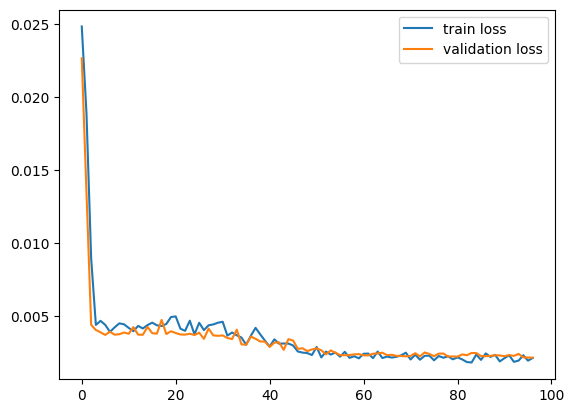

In [44]:
vec_losses = losses[["epoch", "tr_huber", "val_huber"]].values

plt.plot(vec_losses[:, 0], vec_losses[:, 1], label="train loss")
plt.plot(vec_losses[:, 0], vec_losses[:, 2], label="validation loss")
plt.legend()
plt.show()

We managed with our imporovements to get a very good result, improving from our regression model! Probably we have still space from improvement, looking at the graph. For example, the $\delta$ choice in Huber Loss can be done more firmly via a rigorous mathematical estimation.
But did you notice the price of this improvement? We had to train an _huge_ model. That's a very severe tradeoff that we need to do with DL. Possibly, we could reach even better MAE by focusing more on regression